In [1]:
import os
os.chdir('../')

In [2]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.utils import make_grid

from src.XAI.concept import Concept

In [3]:
#load_path = "models/qrunner_dqn_20241031_183101.pth"
load_path = "models/qrunner_dqn_20241105_231944.pth"
model_weights = torch.load(load_path, weights_only=True)
model_weights.keys()

odict_keys(['feature_extractor.0.weight', 'feature_extractor.2.weight', 'feature_extractor.4.weight', 'fc.0.weight', 'fc.0.bias', 'output.weight', 'output.bias'])

In [4]:
weights = model_weights['feature_extractor.0.weight']
print(weights.shape)
# Swap kernel width/height to plot canonically
weights = weights.data.clone().permute(0, 1, 3, 2)
print(weights.shape)

torch.Size([32, 3, 8, 8])
torch.Size([32, 3, 8, 8])


In [5]:
# Normalize weights to be between 0 and 1
weights_normalized = (weights - weights.min()) / (weights.max() - weights.min())

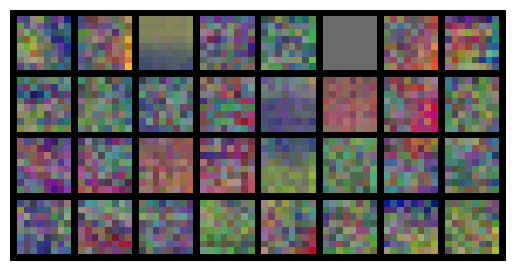

In [6]:
weights_grid = make_grid(weights_normalized, nrow=8, padding=1)
plt.imshow(weights_grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

In [7]:
env_steps = Concept.load_concept_data()
samples = 5000

observations = [step.observation for step in env_steps[:samples]]
observations = np.array(observations)
observations = torch.from_numpy(observations).float()
observations.shape

pygame 2.6.0 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


torch.Size([5000, 3, 84, 84])

In [8]:
# Lets apply convolution to the observations
observations = observations.view(samples, 3, 84, 84)
conv_weights = model_weights['feature_extractor.0.weight'].cpu()
conv_outputs = F.conv2d(observations, conv_weights, stride=4)
conv_outputs = F.relu(conv_outputs)
print(conv_outputs.shape)

torch.Size([5000, 32, 20, 20])


torch.Size([32, 20, 20])


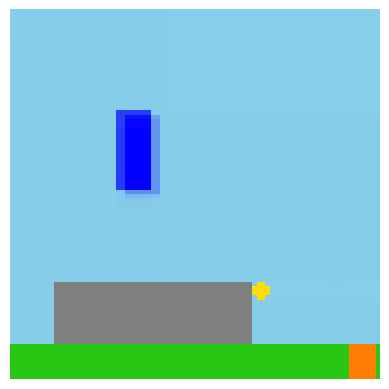

torch.Size([3, 85, 169])


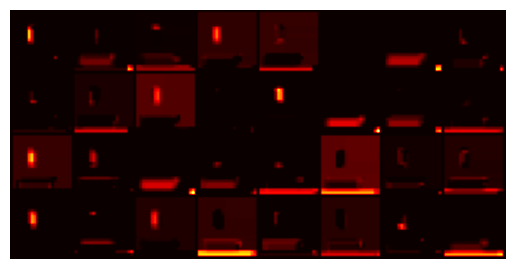

In [75]:
# Lets take a look at a single observation
example_idx = 23
conv_output = conv_outputs[example_idx]
example_obs = observations[example_idx].permute(2, 1, 0).cpu().numpy()
example_obs = (example_obs - example_obs.min()) / (example_obs.max() - example_obs.min())
print(conv_output.shape)
plt.imshow(example_obs)
plt.axis('off')
plt.show()

activations_grid = make_grid(conv_output.permute(0, 2, 1).unsqueeze(1), nrow=8, padding=1)
print(activations_grid.shape)
plt.imshow(activations_grid[0], cmap='hot')
plt.axis('off')
plt.show()

In [76]:
conv_outputs.shape

torch.Size([5000, 32, 20, 20])

In [77]:
kernel_idx = 2
width_idx = 0
height_idx = 18

activations = conv_outputs[:, kernel_idx, width_idx, height_idx]
sorted_activations, sorted_indices = torch.sort(activations, descending=True)

tensor([110.5231, 110.5231, 110.5231, 110.5231, 110.5231, 110.5231, 110.5231,
        110.5231, 110.5231, 110.5231])


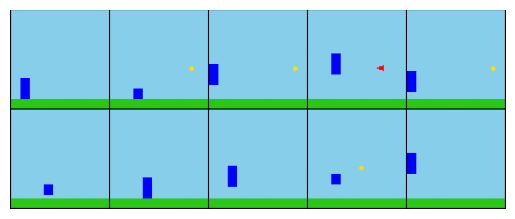

In [78]:
top_indices = sorted_indices[:10]
print(sorted_activations[:10])

top_activations = observations[top_indices].permute(0, 1, 3, 2)
top_activations_grid = make_grid(top_activations, nrow=5, padding=1, normalize=True)
plt.imshow(top_activations_grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

In [79]:
conv2_weights = model_weights['feature_extractor.2.weight'].cpu()
fc_outputs = F.conv2d(conv_outputs, conv2_weights, stride=2)
conv2_outputs = F.relu(fc_outputs)
conv2_output = conv2_outputs[example_idx]
fc_outputs = conv2_outputs.view(samples, -1)
fc_outputs.shape

torch.Size([5000, 2592])

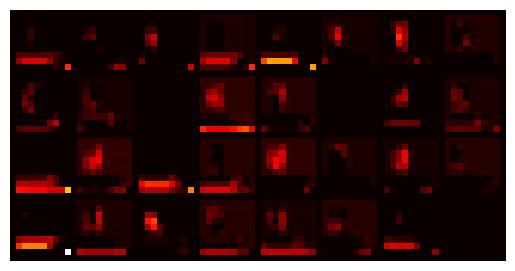

In [80]:
# Plot conv2 outputs
conv2_output_grid = make_grid(conv2_output.permute(0, 2, 1).unsqueeze(1), nrow=8, padding=1, normalize=True)
plt.imshow(conv2_output_grid[0].cpu().numpy(), cmap='hot')
plt.axis('off')
plt.show()

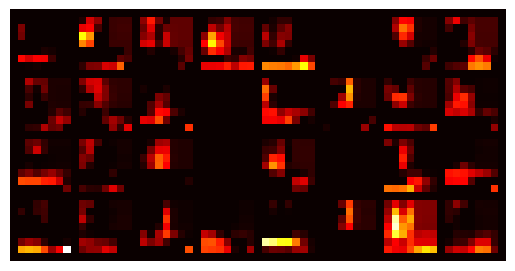

In [81]:
conv3_weights = model_weights['feature_extractor.4.weight'].cpu()
fc_outputs = F.conv2d(conv2_outputs, conv3_weights, stride=1)
conv3_outputs = F.relu(fc_outputs)
conv3_output = conv3_outputs[example_idx]
fc_outputs = conv3_outputs.view(samples, -1)
fc_outputs.shape

# plot conv3 outputs
conv3_output_grid = make_grid(conv3_output.permute(0, 2, 1).unsqueeze(1), nrow=8, padding=1, normalize=True)
plt.imshow(conv3_output_grid[0].cpu().numpy(), cmap='hot')
plt.axis('off')
plt.show()

tensor([86.7848, 72.4303, 54.2788, 53.7120, 53.6075, 53.2474, 52.9335, 52.9107,
        51.5720, 50.7755])


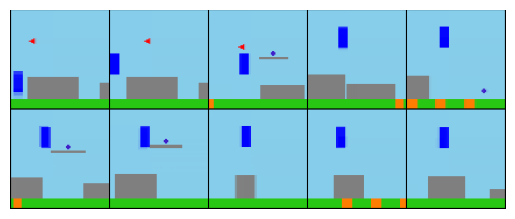

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


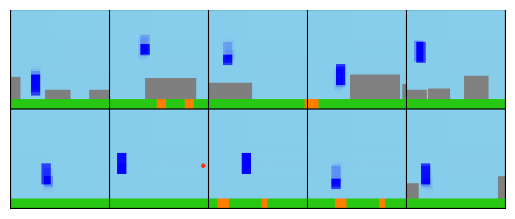

In [89]:
# Sort fc outputs on neuron x
neuron_idx = 0
sorted_fc_outputs, sorted_indices = torch.sort(fc_outputs[:, neuron_idx], descending=True)
top_indices = sorted_indices[:10]
print(sorted_fc_outputs[:10])
top_activations = observations[top_indices].permute(0, 1, 3, 2)
top_activations_grid = make_grid(top_activations, nrow=5, padding=1, normalize=True)
plt.imshow(top_activations_grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

# plot worst 10
bottom_indices = sorted_indices[-10:]
print(sorted_fc_outputs[-10:])
bottom_activations = observations[bottom_indices].permute(0, 1, 3, 2)
bottom_activations_grid = make_grid(bottom_activations, nrow=5, padding=1, normalize=True)
plt.imshow(bottom_activations_grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

In [83]:
# Lets use t-SNE to map the activations to 2D space
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_outputs = tsne.fit_transform(fc_outputs)
print(tsne_outputs.shape)


(5000, 2)


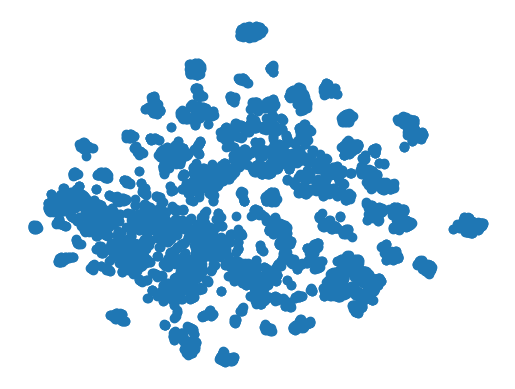

In [84]:
# Plot the observations in 2D space
plt.scatter(tsne_outputs[:, 0], tsne_outputs[:, 1])
plt.axis('off')
plt.show()

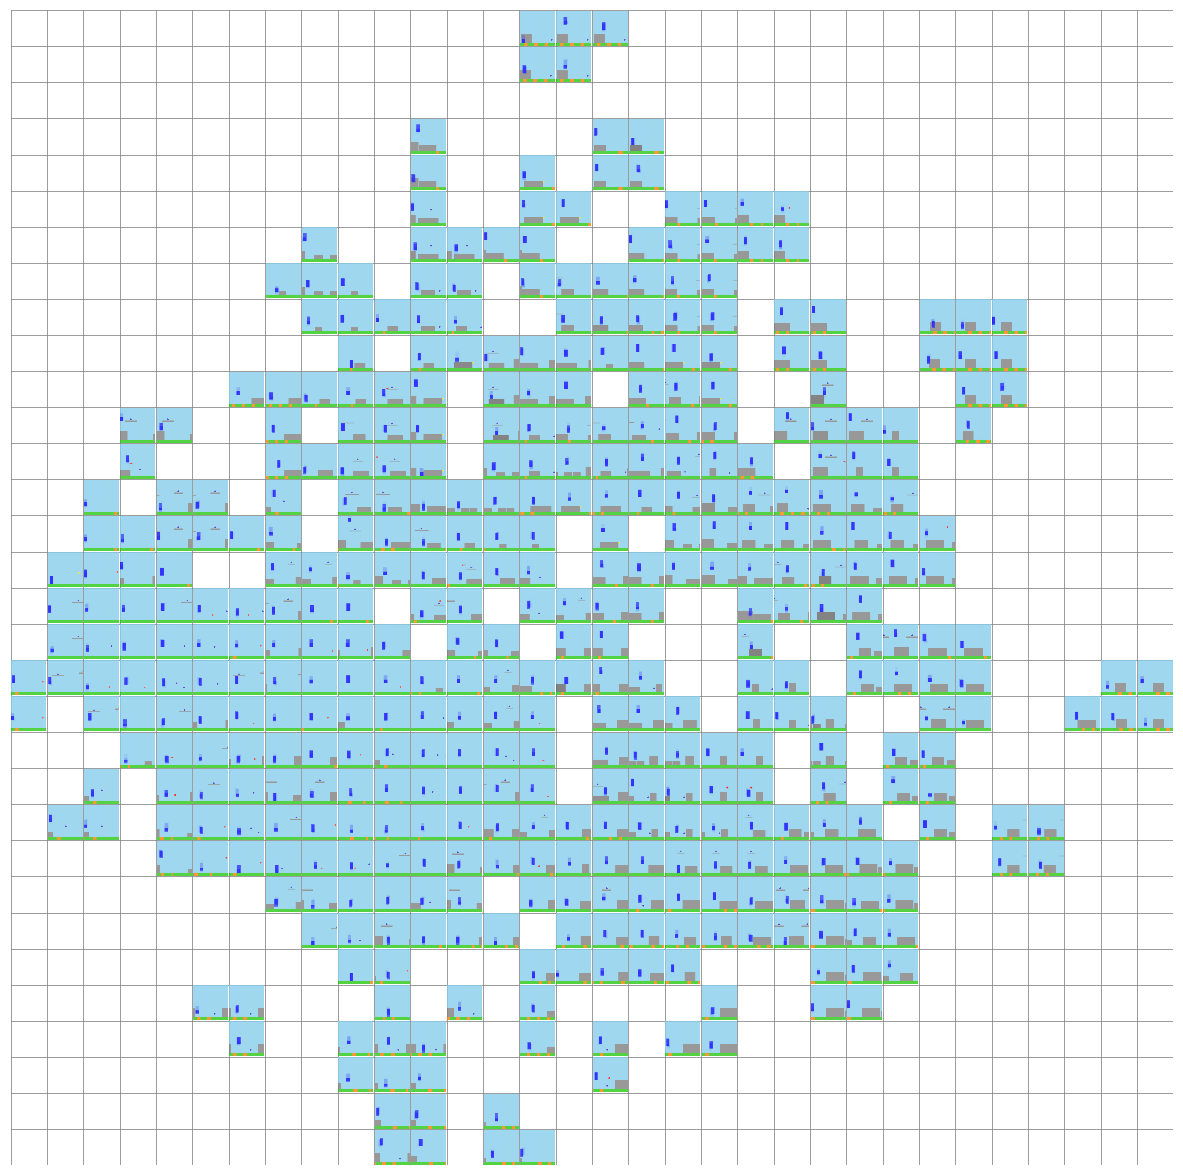

In [85]:
# Cell [16]: Robust t-SNE Visualization Mapped to a Grid with Gridlines

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import random

# Parameters for the grid
grid_size = 32  # Number of grid cells along each axis
image_zoom = 0.3  # Adjust the zoom level for images

# Normalize t-SNE outputs to [0, 1]
tsne_min = tsne_outputs.min(axis=0)
tsne_max = tsne_outputs.max(axis=0)
tsne_normalized = (tsne_outputs - tsne_min) / (tsne_max - tsne_min)

# Map normalized t-SNE coordinates to grid indices
# Ensure indices are within [0, grid_size - 1]
grid_indices = np.floor(tsne_normalized * grid_size).astype(int)
grid_indices = np.clip(grid_indices, 0, grid_size - 1)

# Initialize a grid dictionary to hold lists of image indices for each cell
grid = {}
for idx, (x, y) in enumerate(grid_indices):
    key = (x, y)
    if key not in grid:
        grid[key] = []
    grid[key].append(idx)

# Randomly select one image per grid cell if multiple images are assigned to the same cell
selected_indices = []
for key in grid:
    selected_indices.append(random.choice(grid[key]))

# Prepare the subset of images to plot
images_to_plot = observations[selected_indices]
tsne_subset = tsne_normalized[selected_indices]

# Define a function to create an OffsetImage with corrected orientation
def get_image(obs):
    # Convert the tensor to numpy and permute dimensions to (H, W, C)
    image = obs.permute(2, 1, 0).cpu().numpy()  # Corrected permutation
    # Normalize the image to [0, 1]
    image = (image - image.min()) / (image.max() - image.min())
    return OffsetImage(image, zoom=image_zoom, cmap='gray', alpha=0.8)

# Create a plot
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Iterate over the selected images and place them in the grid
for img, (x_norm, y_norm) in zip(images_to_plot, tsne_subset):
    # Calculate grid cell indices
    x_idx = int(x_norm * grid_size)
    y_idx = int(y_norm * grid_size)
    x_idx = min(x_idx, grid_size - 1)  # Ensure index is within bounds
    y_idx = min(y_idx, grid_size - 1)
    
    # Calculate the center position of the grid cell
    cell_width = 1.0 / grid_size
    cell_height = 1.0 / grid_size
    img_x = (x_idx + 0.5) * cell_width
    img_y = (y_idx + 0.5) * cell_height
    
    # Create an OffsetImage and AnnotationBbox
    image = get_image(img)
    ab = AnnotationBbox(image, (img_x, img_y), frameon=False, pad=0.1)
    ax.add_artist(ab)

# Draw gridlines
for i in range(grid_size + 1):
    # Vertical lines
    ax.axvline(i / grid_size, color='lightgrey', linewidth=0.5)
    # Horizontal lines
    ax.axhline(i / grid_size, color='lightgrey', linewidth=0.5)

# Optional: Add grid cell borders for better visibility
for i in range(grid_size + 1):
    ax.axvline(i / grid_size, color='grey', linewidth=0.5)
    ax.axhline(i / grid_size, color='grey', linewidth=0.5)

# Remove axes for better visualization
plt.axis('off')
plt.show()

In [86]:
fc_outputs.shape

torch.Size([5000, 1568])

In [87]:
# Cell [18]: Apply NMF and Cluster Assignments
from sklearn.decomposition import NMF

# Number of clusters
n_clusters = 10

# Initialize NMF with the desired number of components
nmf = NMF(n_components=n_clusters, random_state=42)

# Fit NMF on fc_outputs and get the components
nmf_components = nmf.fit_transform(fc_outputs)

[2495 4905  497 4373 4498 3055 3998   23  238 3418]


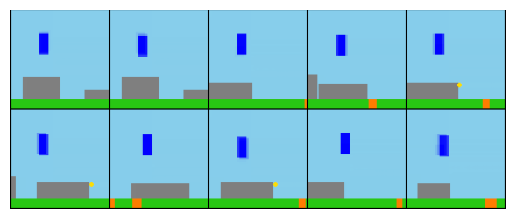

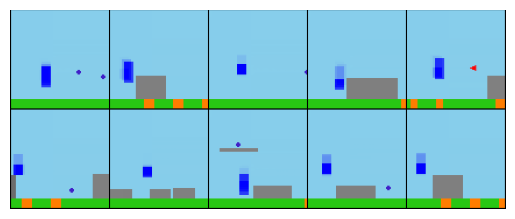

In [88]:
# Sort the observations, with lambda, based on cluster 0 activations
cluster_idx = 4
sorted_activations = nmf_components[:, cluster_idx]
indices = np.argsort(sorted_activations)[::-1]
top_indices = indices[:10]
print(top_indices)
top_activations = observations[top_indices.copy()].permute(0, 1, 3, 2)
top_activations_grid = make_grid(top_activations, nrow=5, padding=1, normalize=True)
plt.imshow(top_activations_grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

# and the worst 10
bottom_indices = indices[-10:]
bottom_activations = observations[bottom_indices.copy()].permute(0, 1, 3, 2)
bottom_activations_grid = make_grid(bottom_activations, nrow=5, padding=1, normalize=True)
plt.imshow(bottom_activations_grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()